In [0]:
# import tensorflow as tf 
# tf.test.gpu_device_name() 

'/device:GPU:0'

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", -1)

import numpy as np

import pandas_profiling

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set_context("paper", font_scale=1.8)
sns.set_palette("GnBu_d")

import pickle

import math

***step*** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

***type*** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

***amount*** - amount of the transaction in local currency (assume $).

***nameOrig*** - customer who started the transaction

***oldbalanceOrg*** - initial balance before the transaction

***newbalanceOrig*** - new balance after the transaction

***nameDest*** - customer who is the recipient of the transaction

***oldbalanceDest*** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

***newbalanceDest*** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

***isFraud*** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

***isFlaggedFraud*** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than $200,000 in a single transaction.

In [0]:
# from google.colab import auth
# auth.authenticate_user()

# from pydrive.drive import GoogleDrive
# from pydrive.auth import GoogleAuth
# from oauth2client.client import GoogleCredentials
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [0]:
# myfile = drive.CreateFile({"id": "1qW2WhTNFtrZY5GVLsZRjl5O2xD1ws7Hn"})
# myfile.GetContentFile("file.csv")

In [76]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv") 

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              6362620 non-null int64
type              6362620 non-null object
amount            6362620 non-null float64
nameOrig          6362620 non-null object
oldbalanceOrg     6362620 non-null float64
newbalanceOrig    6362620 non-null float64
nameDest          6362620 non-null object
oldbalanceDest    6362620 non-null float64
newbalanceDest    6362620 non-null float64
isFraud           6362620 non-null int64
isFlaggedFraud    6362620 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [77]:
# Rename column headers to indicate months
df.rename(mapper={
    "nameOrig": "customer",
    "oldbalanceOrg": "customer_old_balance",
    "newbalanceOrig": "customer_new_balance",
    "nameDest": "recipient",
    "oldbalanceDest": "recipient_old_balance",
    "newbalanceDest": "recipient_new_balance",
    "isFraud": "is_fraud",
    "isFlaggedFraud": "is_flagged_fraud"
},
          axis=1,
          inplace=True)

df.head()

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [0]:
# Descriptive statistics
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,6.36262e+06,NaN,NaN,NaN,243.397,142.332,1,156,239,335,743
type,6362620,5,CASH_OUT,2237500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,6.36262e+06,NaN,NaN,NaN,179862,603858,0,13389.6,74871.9,208721,9.24455e+07
customer,6362620,6353307,C1462946854,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_old_balance,6.36262e+06,NaN,NaN,NaN,833883,2.88824e+06,0,0,14208,107315,5.9585e+07
customer_new_balance,6.36262e+06,NaN,NaN,NaN,855114,2.92405e+06,0,0,0,144258,4.9585e+07
recipient,6362620,2722362,C1286084959,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recipient_old_balance,6.36262e+06,NaN,NaN,NaN,1.1007e+06,3.39918e+06,0,0,132706,943037,3.56016e+08
recipient_new_balance,6.36262e+06,NaN,NaN,NaN,1.225e+06,3.67413e+06,0,0,214661,1.11191e+06,3.56179e+08
is_fraud,6.36262e+06,NaN,NaN,NaN,0.00129082,0.0359048,0,0,0,0,1


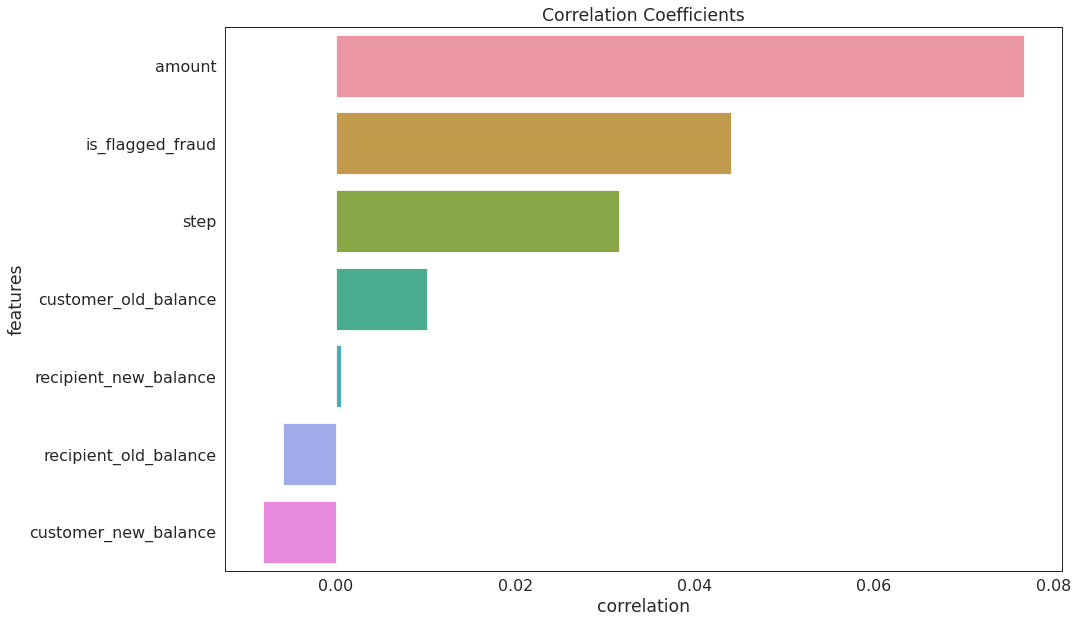

In [0]:
corr_table = df.corr()[["is_fraud"]].sort_values("is_fraud", ascending=False).iloc[1:,:].reset_index()
plt.figure(figsize=(15,10))
sns.barplot(x="is_fraud", y="index", data=corr_table)
plt.xlabel("correlation")
plt.ylabel("features")
plt.title("Correlation Coefficients")
plt.show()

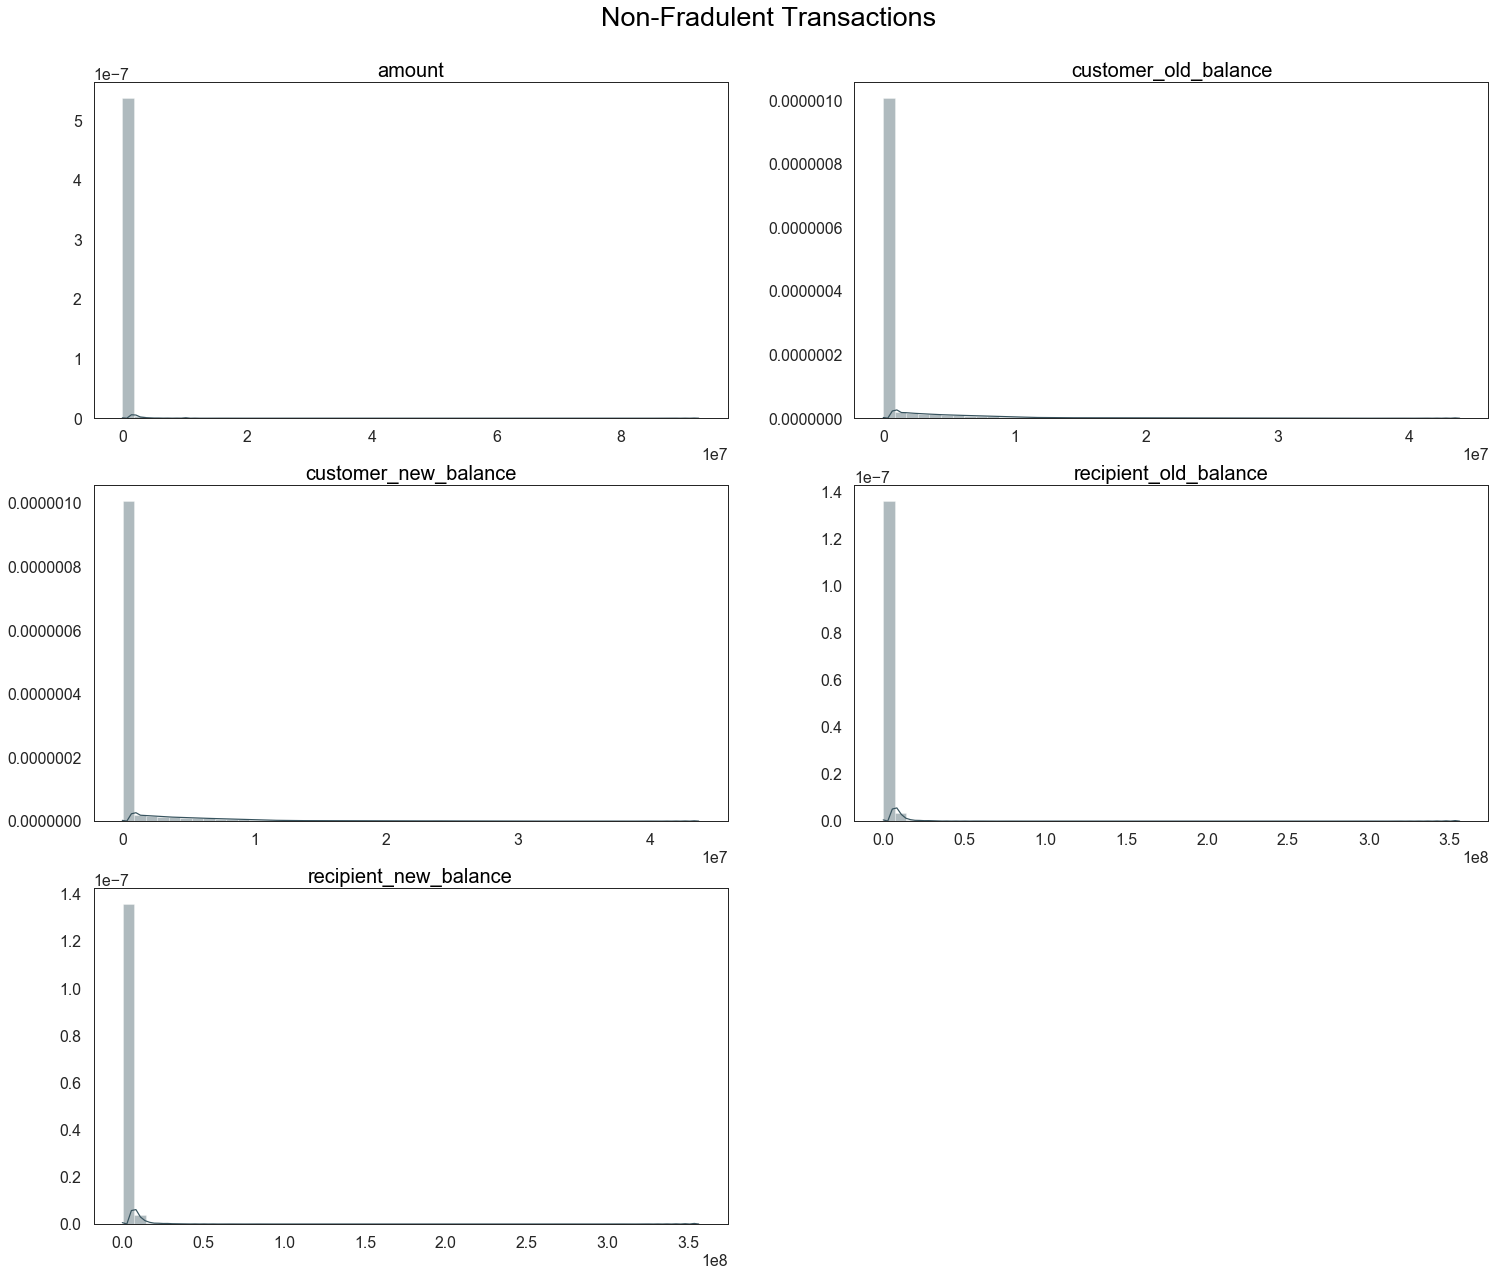

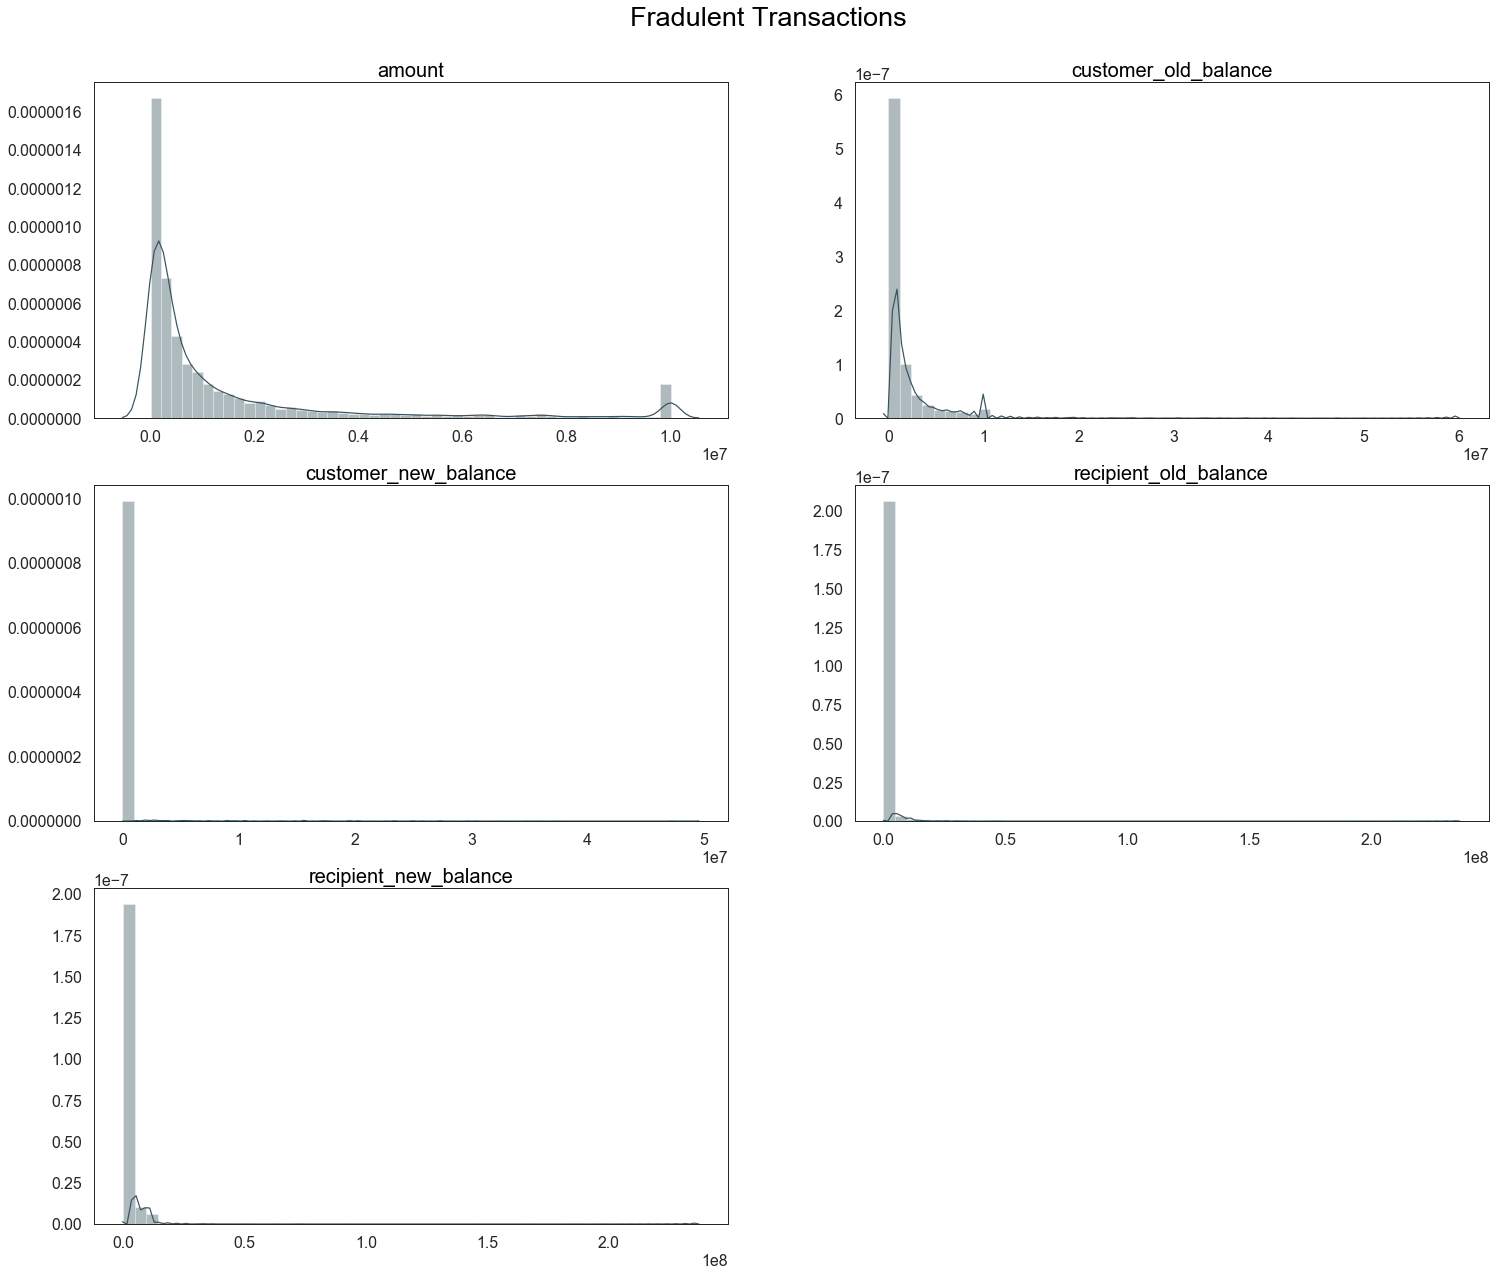

In [11]:
cols = [
    "amount", "customer_old_balance", "customer_new_balance",
    "recipient_old_balance", "recipient_new_balance"
]

r = math.ceil(len(cols)/2)

for key, val in enumerate(["Non-Fradulent Transactions", "Fradulent Transactions"]):
    fig = plt.figure(figsize=(25, 7*r))
    for i, col in enumerate(cols):
        ax = fig.add_subplot(r, 2, i + 1)
        sns.distplot(df.query("is_fraud == @key")[col])
        plt.xlabel(None)
        plt.title(col, fontsize=20, color="black")
    plt.suptitle(val, fontsize=27, y=0.93, color="black")
    plt.show()

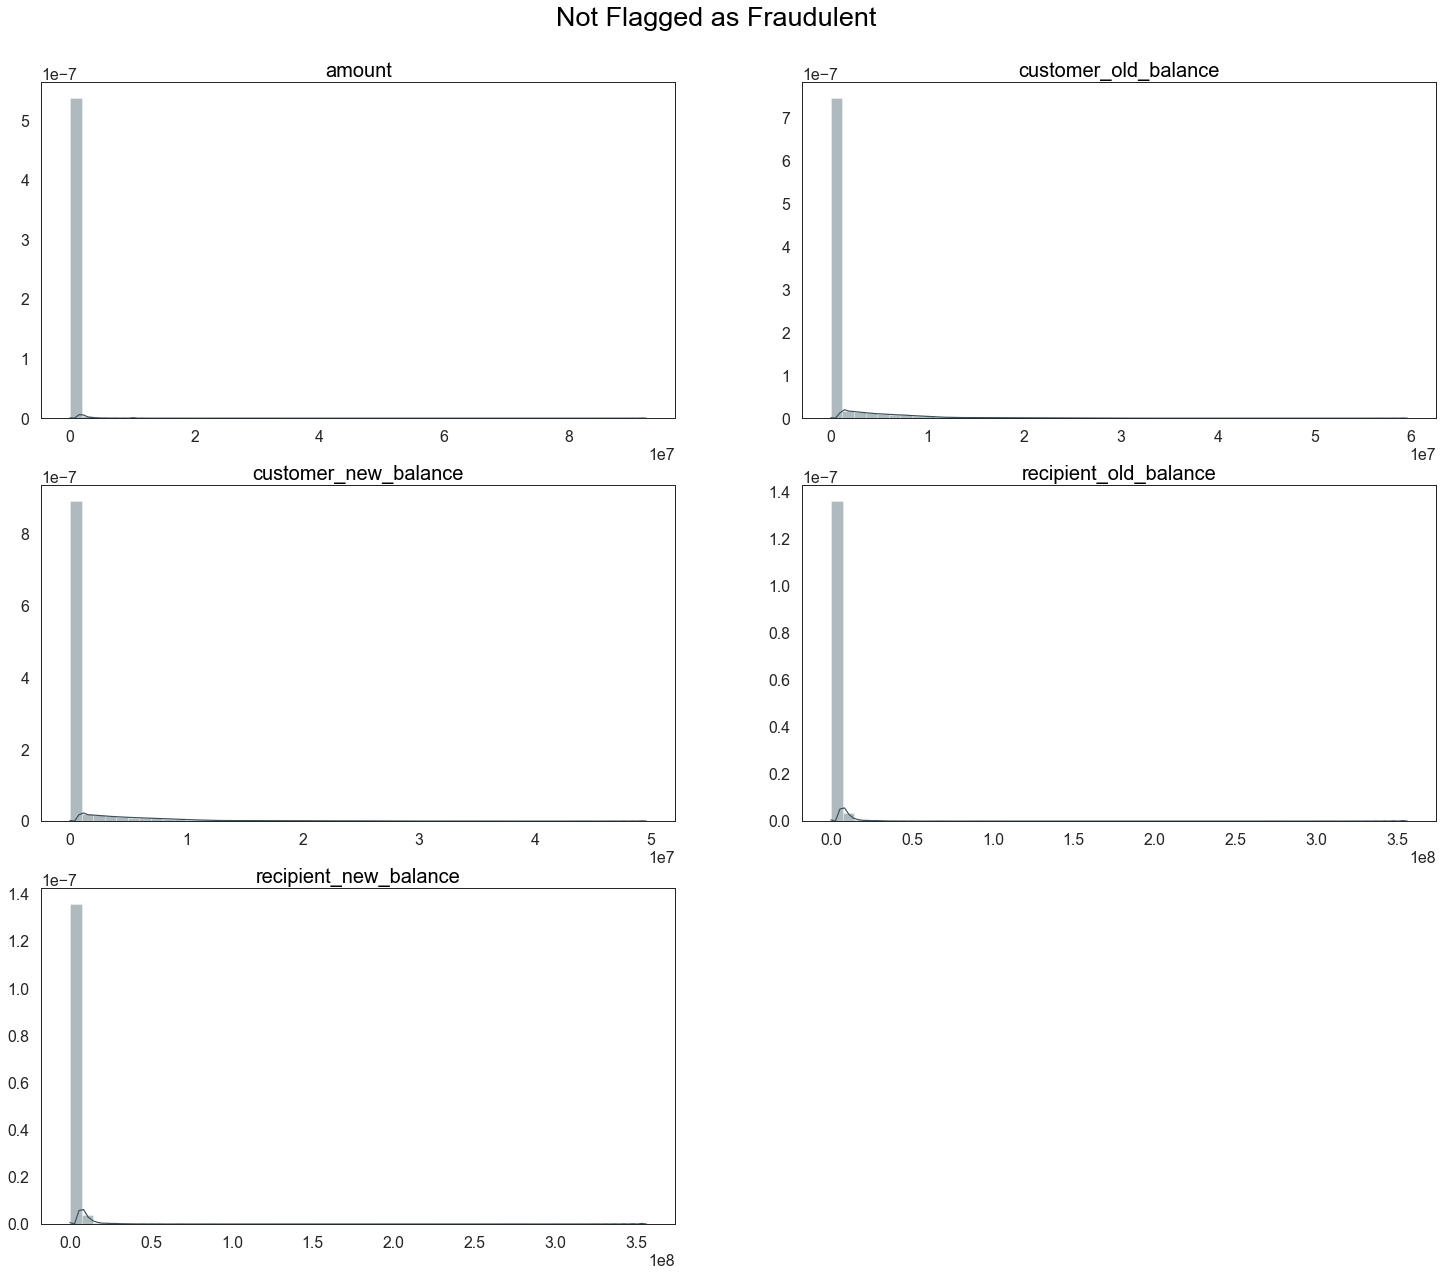

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


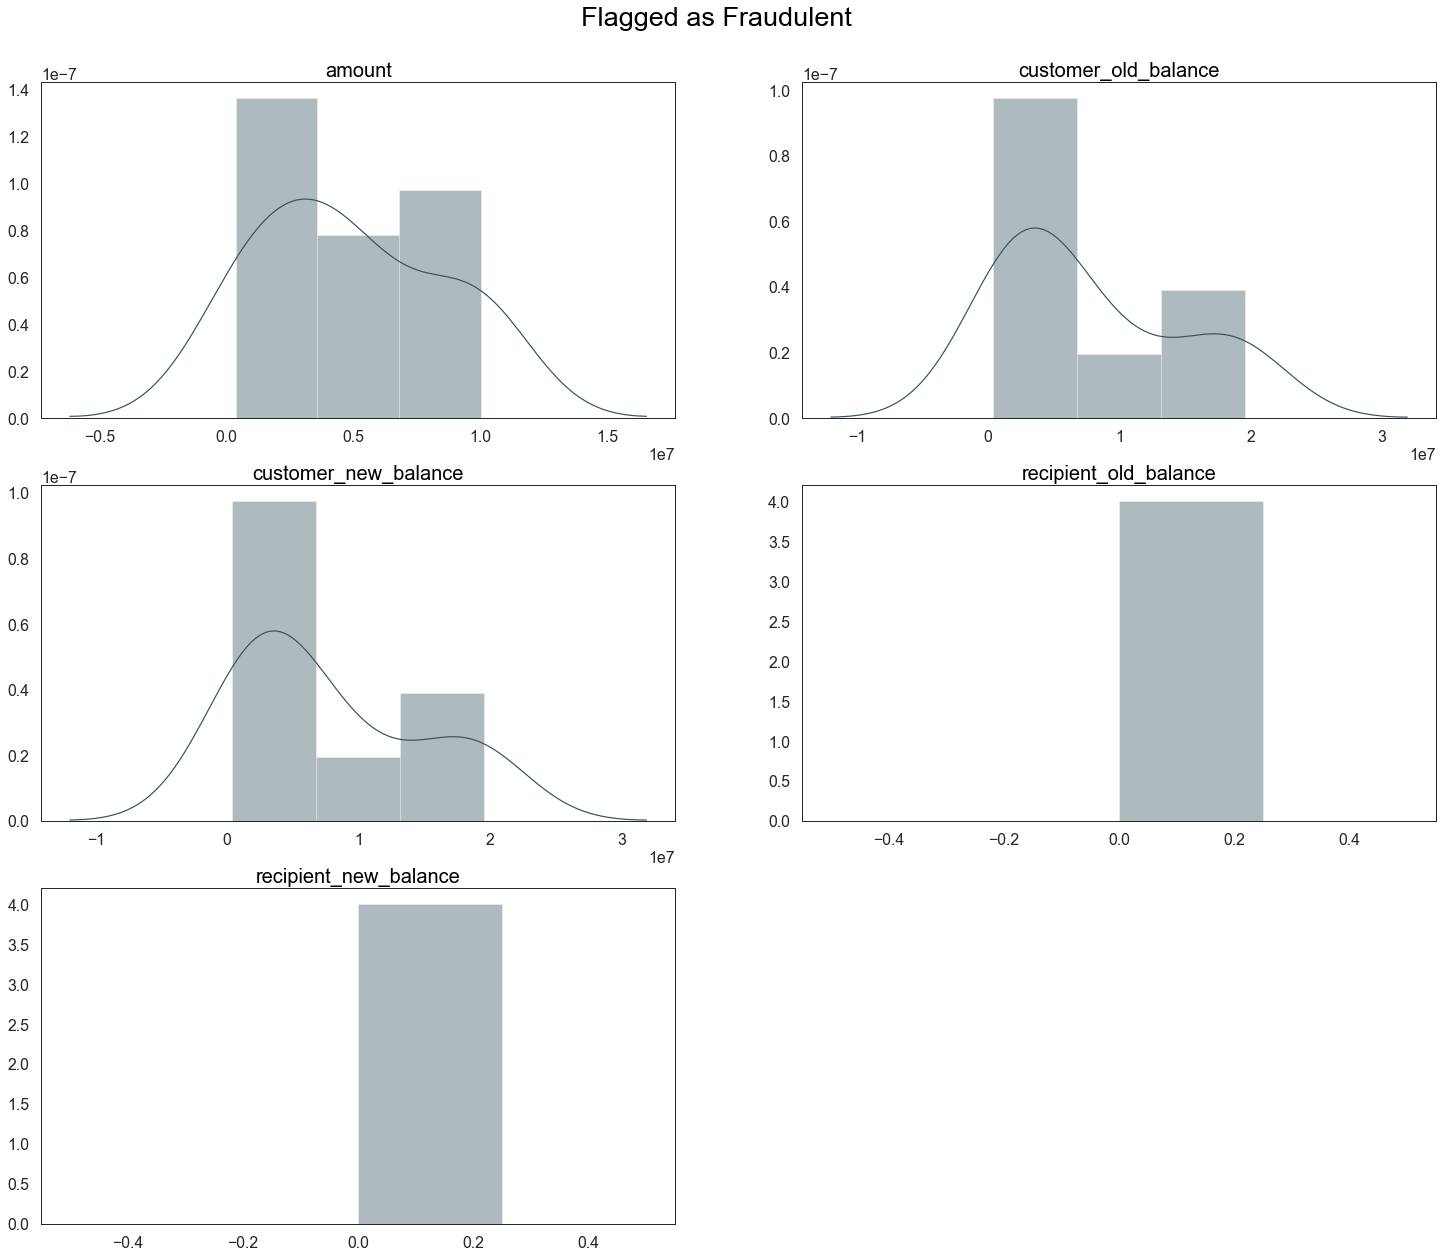

In [12]:
cols = [
    "amount", "customer_old_balance", "customer_new_balance",
    "recipient_old_balance", "recipient_new_balance"
]

r = math.ceil(len(cols)/2)

for key, val in enumerate(["Not Flagged as Fraudulent", "Flagged as Fraudulent"]):
    fig = plt.figure(figsize=(25, 7*r))
    for i, col in enumerate(cols):
        ax = fig.add_subplot(r, 2, i + 1)
        sns.distplot(df.query("is_flagged_fraud == @key")[col])
        plt.xlabel(None)
        plt.title(col, fontsize=20, color="black")
    plt.suptitle(val, fontsize=27, y=0.93, color="black")
    plt.show()

In [0]:
cols = ["type", "is_fraud", "is_flagged_fraud"]
print("=====All Transactions=====")
for col in cols:
    print("FEATURE: ", col)
    print(df[col].value_counts(normalize=True)*100)

=====All Transactions=====
FEATURE:  type
CASH_OUT    35.166331
PAYMENT     33.814608
CASH_IN     21.992261
TRANSFER    8.375622 
DEBIT       0.651178 
Name: type, dtype: float64
FEATURE:  is_fraud
0    99.870918
1    0.129082 
Name: is_fraud, dtype: float64
FEATURE:  is_flagged_fraud
0    99.999749
1    0.000251 
Name: is_flagged_fraud, dtype: float64


In [0]:
cols = ["type", "is_flagged_fraud"]

print("=====Fraudulent Transactions=====")
for col in cols:
    print("FEATURE: ", col)
    print(df.query("is_fraud == 1")[col].value_counts(normalize=True)*100)

print("\n=====Non-Fraudulent Transactions=====")
for col in cols:
    print("FEATURE: ", col)
    print(df.query("is_fraud == 0")[col].value_counts(normalize=True)*100)

=====Fraudulent Transactions=====
FEATURE:  type
CASH_OUT    50.11567
TRANSFER    49.88433
Name: type, dtype: float64
FEATURE:  is_flagged_fraud
0    99.805187
1    0.194813 
Name: is_flagged_fraud, dtype: float64

=====Non-Fraudulent Transactions=====
FEATURE:  type
CASH_OUT    35.147009
PAYMENT     33.858313
CASH_IN     22.020686
TRANSFER    8.321972 
DEBIT       0.652020 
Name: type, dtype: float64
FEATURE:  is_flagged_fraud
0    100.0
Name: is_flagged_fraud, dtype: float64


In [0]:
cols = ["type", "is_fraud"]

print("=====Flagged as Fraudulent=====")
for col in cols:
    print("FEATURE: ", col)
    print(df.query("is_flagged_fraud == 1")[col].value_counts(normalize=True)*100)
  
print("\n=====Not Flagged as Fraudulent=====")
for col in cols:
    print("FEATURE: ", col)
    print(df.query("is_flagged_fraud == 0")[col].value_counts(normalize=True)*100)

=====Flagged as Fraudulent=====
FEATURE:  type
TRANSFER    100.0
Name: type, dtype: float64
FEATURE:  is_fraud
1    100.0
Name: is_fraud, dtype: float64

=====Not Flagged as Fraudulent=====
FEATURE:  type
CASH_OUT    35.166419
PAYMENT     33.814693
CASH_IN     21.992316
TRANSFER    8.375392 
DEBIT       0.651180 
Name: type, dtype: float64
FEATURE:  is_fraud
0    99.871169
1    0.128831 
Name: is_fraud, dtype: float64


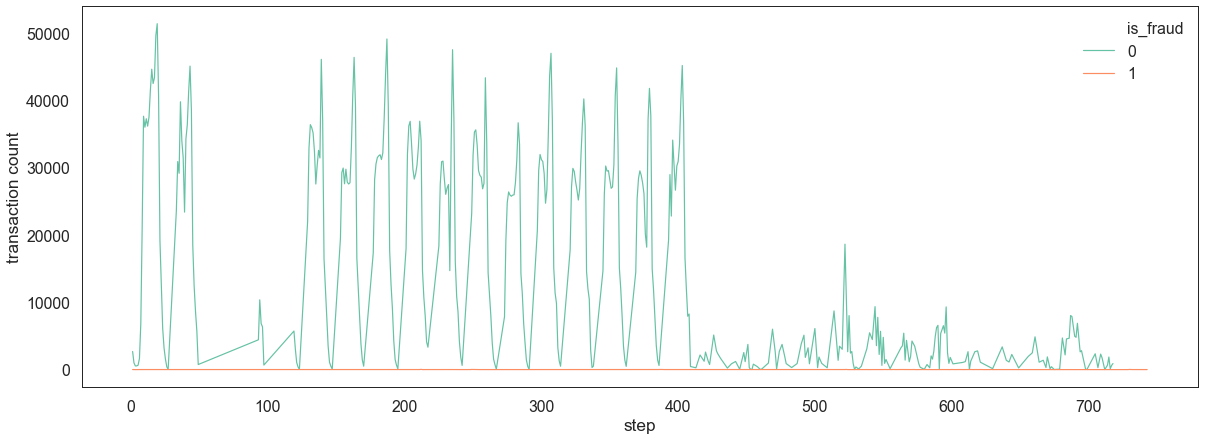

In [18]:
plt.figure(figsize=(20, 7))
sns.lineplot(x="step",
             y="amount",
             hue="is_fraud",
             data=df.groupby(["step", "is_fraud"]).count().reset_index(),
             palette="Set2")
plt.xlabel("step")
plt.ylabel("transaction count")
plt.show()

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


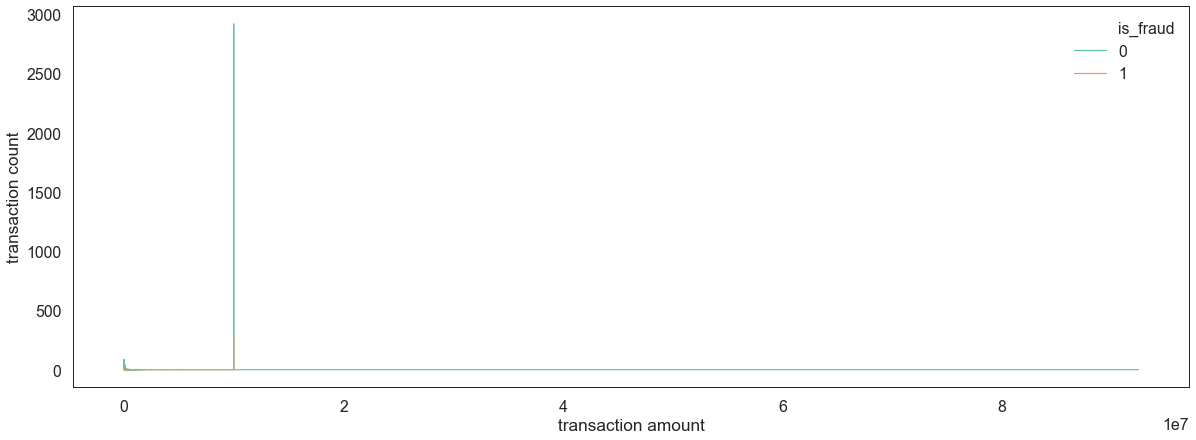

In [20]:
plt.figure(figsize=(20, 7))
sns.lineplot(x="amount",
             y="step",
             hue="is_fraud",
             data=df.groupby(["amount", "is_fraud"]).count().reset_index(),
             palette="Set2")
plt.xlabel("transaction amount")
plt.ylabel("transaction count")
plt.show()

In [21]:
print("There are {} customers appeared more than once.".format(
    len(df[df.customer.duplicated(keep="first") == True].customer)))

There are 9313 customers appeared more than once.


In [22]:
print("There are {} recipients appeared more than once.".format(
    len(df[df.recipient.duplicated(keep="first") == True].recipient)))

There are 3640258 recipients appeared more than once.


In [23]:
print("There are {} IDs that are both customer and recipient.".format(
    len(
        pd.DataFrame(df.customer.unique()).merge(pd.DataFrame(
            df.recipient.unique()),
                                                 how="inner"))))

There are 1769 IDs that are both customer and recipient.


In [24]:
print("There are {} merchants that initiated transactions.".format(
    len(df[df.customer.str.contains("M")])))

There are 0 merchants that initiated transactions.


In [25]:
print("There are {} merchants as recipients.".format(
    len(df[df.recipient.str.contains("M")])))

There are 2151495 merchants as recipients.


In [26]:
cols = ["type", "is_fraud", "is_flagged_fraud"]
print("=====Merchant as Recipient=====")
for col in cols:
    print("FEATURE: ", col)
    print(df[df.recipient.str.contains("M")][col].value_counts(normalize=True)*100)

=====Merchant as Recipient=====
FEATURE:  type
PAYMENT    100.0
Name: type, dtype: float64
FEATURE:  is_fraud
0    100.0
Name: is_fraud, dtype: float64
FEATURE:  is_flagged_fraud
0    100.0
Name: is_flagged_fraud, dtype: float64


In [27]:
repeated_customer = df[df.customer.duplicated(keep=False) == True][[
    "step", "customer", "amount", "is_fraud"
]].sort_values(["customer", "step"]).reset_index(drop=False)

for i in range(1, len(repeated_customer)):
    if (repeated_customer.customer.iloc[i] == repeated_customer.customer.iloc[
            i - 1]) & (repeated_customer.step.iloc[i] >
                       repeated_customer.step.iloc[i - 1]) & (
                           repeated_customer.is_fraud.iloc[i - 1] == 1):
        repeated_customer.at[i, "customer_with_prior"] = 1
    else:
        repeated_customer.at[i, "customer_with_prior"] = 0
repeated_customer.at[0, "customer_with_prior"] = 0
repeated_customer.customer_with_prior = repeated_customer.customer_with_prior.astype(
    "int64", errors="ignore")

repeated_customer.set_index("index", drop=True, inplace=True)
repeated_customer.head()

,step,customer,amount,is_fraud,customer_with_prior
index,,,,,
3359372,254,C100025963,21813.13,0,0
3699311,277,C100025963,68949.69,0,0
279050,15,C1000442951,44373.09,0,0
4982860,352,C1000442951,146953.48,0,0
3123272,236,C1000947901,29929.79,0,0


In [28]:
repeated_recipient = df[df.recipient.duplicated(keep=False) == True][[
    "step", "recipient", "amount", "is_fraud"
]].sort_values(["recipient", "step"]).reset_index(drop=False)

for i in range(1, len(repeated_recipient)):
    if (repeated_recipient.recipient.iloc[i] == repeated_recipient.recipient.
            iloc[i - 1]) & (repeated_recipient.step.iloc[i] >
                            repeated_recipient.step.iloc[i - 1]) & (
                                repeated_recipient.is_fraud.iloc[i - 1] == 1):
        repeated_recipient.at[i, "recipient_with_prior"] = 1
    else:
        repeated_recipient.at[i, "recipient_with_prior"] = 0
repeated_recipient.at[i, "recipient_with_prior"] = 0
repeated_recipient.recipient_with_prior = repeated_recipient.recipient_with_prior.astype(
    "int64", errors="ignore")

repeated_recipient.set_index("index", drop=True, inplace=True)
repeated_recipient.head()

,step,recipient,amount,is_fraud,recipient_with_prior
index,,,,,
4987517,352,C1000004082,156985.31,0,NaN
5032095,354,C1000004082,228252.33,0,0.0
5219127,370,C1000004082,1331742.99,0,0.0
5331822,374,C1000004082,363030.74,0,0.0
5462768,379,C1000004082,156015.83,0,0.0


In [78]:
df = pd.merge(df,
              repeated_customer.customer_with_prior,
              left_index=True,
              right_index=True,
              how="left")
df = pd.merge(df,
              repeated_recipient.recipient_with_prior,
              left_index=True,
              right_index=True,
              how="left")
df.head()

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud,customer_with_prior,recipient_with_prior
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,NaN,NaN
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,NaN,NaN
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,NaN,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,NaN,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,NaN,NaN


In [81]:
df.fillna(0, inplace=True)
df.customer_with_prior = df.customer_with_prior.astype("int64", errors="ignore")
df.recipient_with_prior = df.recipient_with_prior.astype("int64", errors="ignore")
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
step                     6362620 non-null int64
type                     6362620 non-null object
amount                   6362620 non-null float64
customer                 6362620 non-null object
customer_old_balance     6362620 non-null float64
customer_new_balance     6362620 non-null float64
recipient                6362620 non-null object
recipient_old_balance    6362620 non-null float64
recipient_new_balance    6362620 non-null float64
is_fraud                 6362620 non-null int64
is_flagged_fraud         6362620 non-null int64
customer_with_prior      6362620 non-null int64
recipient_with_prior     6362620 non-null int64
dtypes: float64(5), int64(5), object(3)
memory usage: 631.1+ MB


In [82]:
df_fraud = df.query("is_fraud == 1")
df_not_fraud = df.query("is_fraud == 0")
df_flagged = df.query("is_flagged_fraud == 1")
df_not_flagged = df.query("is_flagged_fraud == 0")

In [83]:
print("There are {} customers with fraudulent transactions".format(
    df_fraud.customer.nunique()))

There are 8213 customers with fraudulent transactions


In [84]:
print("There are {} recipient under fraudulent transactions".format(
    df_fraud.recipient.nunique()))

There are 8169 recipient under fraudulent transactions


In [85]:
print(
    "There are {} customers who have made both fraudulent and non-fraudulent transactions."
    .format(
        len(df_fraud[["customer"]].merge(df_not_fraud[["customer"]],
                                         how="inner"))))

There are 28 customers who have made both fraudulent and non-fraudulent transactions.


In [87]:
print(
    "There are {} IDs who have been recipient of both fraudulent and non-fraudulent transactions."
    .format(
        len(df_fraud[["recipient"]].merge(df_not_fraud[["recipient"]],
                                         how="inner"))))

There are 58186 IDs who have been recipient of both fraudulent and non-fraudulent transactions.


In [88]:
print(
    "There are {} customers who have both flagged and not flagged transactions ."
    .format(
        len(df_flagged[["customer"]].merge(df_not_flagged[["customer"]],
                                           how="inner"))))

There are 0 customers who have both flagged and not flagged transactions .


In [90]:
print(
    "There are {} recipients who have both flagged and not flagged transactions ."
    .format(
        len(df_flagged[["recipient"]].merge(df_not_flagged[["recipient"]],
                                           how="inner"))))

There are 8 recipients who have both flagged and not flagged transactions .


In [91]:
print(
    "There are {} IDs who have fraudulent transactions as both customer and recipient."
    .format(
        len(df_fraud[["customer"]].merge(df_fraud[["recipient"]],
                                         how="inner",
                                         left_on="customer",
                                         right_on="recipient"))))

There are 0 IDs who have fraudulent transactions as both customer and recipient.


In [92]:
print(
    "There are {} IDs who have fraudulent transactions as customer but none as recipient."
    .format(
        len(df_fraud[["customer"]].merge(df_not_fraud[["recipient"]],
                                         how="inner",
                                         left_on="customer",
                                         right_on="recipient"))))

There are 0 IDs who have fraudulent transactions as customer but none as recipient.


In [93]:
df.query("is_flagged_fraud==0 & (customer_with_prior==1 | recipient_with_prior==1) & is_fraud==1")

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud,customer_with_prior,recipient_with_prior
4858,5,CASH_OUT,120074.73,C1174000532,120074.73,0.0,C410033330,0.00,120074.73,1,0,0,1
1030736,88,CASH_OUT,4022408.76,C987446721,4022408.76,0.0,C1981613973,4542879.50,8565288.26,1,0,0,1
1048324,95,CASH_OUT,87999.25,C409531429,87999.25,0.0,C1827219533,0.00,87999.25,1,0,0,1
1059579,105,CASH_OUT,511379.90,C1440012977,511379.90,0.0,C644163395,3439249.70,3950629.60,1,0,0,1
3208638,249,CASH_OUT,369448.20,C2020495090,369448.20,0.0,C650699445,0.00,369448.20,1,0,0,1
6008662,436,CASH_OUT,4135944.29,C1649836304,4135944.29,0.0,C14138104,0.00,4135944.29,1,0,0,1
6168708,560,CASH_OUT,143275.81,C1571623448,143275.81,0.0,C1655359478,6346481.09,6489756.90,1,0,0,1
6255874,597,CASH_OUT,517183.38,C1850286862,517183.38,0.0,C1837027614,0.00,517183.38,1,0,0,1
6272188,621,CASH_OUT,425861.93,C2103073329,425861.93,0.0,C686334805,203280.85,629142.78,1,0,0,1
6281786,650,CASH_OUT,50523.78,C1711085884,50523.78,0.0,C1148781766,0.00,50523.78,1,0,0,1
